# **Import Libraries**

In [ ]:
# import all the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import locale
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import statsmodels.formula.api as smf

In [ ]:
# set the random seed
seed_value = 2020

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# **Load Data**

In [ ]:
import pandas as pd

# List of stock names
stock_names = ['ABB_Ltd', 'Actelion_Ltd', 'Adecco_Group_AG', 'Compagnie_Financiere_Richemont_SA' ,
               'Credit_Suisse_Group_AG', 'Holcim_AG', 'Julius_Baer_Gruppe_AG', 'Nestle_SA',
               'Novartis_AG', 'Roche_Holding_AG', 'SGS_SA', 'Swatch_Group_AG', 'Swisscom_AG',
               'Syngenta_AG', 'UBS_Group_AG', 'Zuerich_Insurance_Group_AG']

#stock_names = ['ABB_Ltd', 'Holcim_AG', 'Nestle_SA', 'Novartis_AG', 'Swisscom_AG']

n_stocks = len(stock_names)

# Initialize an empty dataframe to store all data
all_data = pd.DataFrame()

# Loop through the stock names and generate file names
for stock_name in stock_names:
    file_name = f'Price History_{stock_name}.csv'
    data = pd.read_csv(file_name, sep=";")

    # Add a new column with the stock name
    data['Stock_Name'] = stock_name

    # Append the data to dataframe all_data
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now, all_data is a single dataframe containing the data for all stocks
# It has a new column 'Stock_Name' with the corresponding stock name

# change Volume column into float
if all_data['Volume'].dtype == 'object':
    all_data['Volume'] = all_data['Volume'].apply(lambda x: float(x.replace('’', '').replace(',', '')))

all_data

,Exchange Date,Close,Open,Low,High,Volume,Stock_Name
0,04-Jan-2010,19.04,18.84,18.79,19.04,7862091.0,ABB_Ltd
1,05-Jan-2010,19.13,19.09,18.97,19.13,8969947.0,ABB_Ltd
2,06-Jan-2010,19.27,19.15,19.08,19.31,5745068.0,ABB_Ltd
3,07-Jan-2010,19.53,19.41,19.21,19.57,12781583.0,ABB_Ltd
4,08-Jan-2010,19.79,19.66,19.53,19.80,11344107.0,ABB_Ltd
...,...,...,...,...,...,...,...
24107,22-Dez-2015,250.30,251.10,248.40,251.70,490177.0,Zuerich_Insurance_Group_AG
24108,23-Dez-2015,255.70,251.50,251.50,256.10,467202.0,Zuerich_Insurance_Group_AG
24109,28-Dez-2015,255.00,255.50,253.00,255.90,308007.0,Zuerich_Insurance_Group_AG
24110,29-Dez-2015,259.80,256.00,255.40,259.80,444517.0,Zuerich_Insurance_Group_AG


# **Data preprocessing**

In [ ]:
# Check the data type of the 'Exchange Date' column
if all_data['Exchange Date'].dtype == 'object':
    # define mapping for month abbreviations
    month_mapping = {
        'Mär': 'Mar',
        'Mai': 'May',
        'Okt': 'Oct',
        'Dez': 'Dec',
    }

    # Check if the date column contains German month abbreviations
    if all_data['Exchange Date'].str.contains('|'.join(month_mapping.keys())).any():
        # replace german month abbreviations
        all_data['Exchange Date'] = all_data['Exchange Date'].replace(month_mapping, regex=True)

        # convert the date column to datetime format
        all_data['Exchange Date'] = pd.to_datetime(all_data['Exchange Date'], format='%d-%b-%Y')

# new column to track only month & year (MAYBE NOT NEEDED)
all_data['Month_Year'] = all_data['Exchange Date'].dt.strftime('%m.%Y')
all_data['Month_Year'] = pd.to_datetime(all_data['Month_Year'], format='%m.%Y')


In [ ]:
# gruop data by Exchange Date & Stock Name, set Exchange Date as index
data_grouped = all_data.reset_index().groupby(['Exchange Date','Stock_Name']).first().reset_index().set_index('Exchange Date')
# delete old index column
del data_grouped['index']
data_grouped

,Stock_Name,Close,Open,Low,High,Volume,Month_Year
Exchange Date,,,,,,,
2010-01-04,ABB_Ltd,19.0400,18.8400,18.7900,19.0400,7862091.0,2010-01-01
2010-01-04,Actelion_Ltd,54.3300,53.9400,53.6000,54.3300,386887.0,2010-01-01
2010-01-04,Adecco_Group_AG,58.5000,57.5000,57.3000,58.5000,732529.0,2010-01-01
2010-01-04,Compagnie_Financiere_Richemont_SA,35.5400,34.9700,34.9100,35.5400,1912981.0,2010-01-01
2010-01-04,Credit_Suisse_Group_AG,46.0669,44.3034,44.1313,46.0669,6038888.0,2010-01-01
...,...,...,...,...,...,...,...
2015-12-30,Swatch_Group_AG,350.2000,351.7000,349.4000,353.9000,121580.0,2015-12-01
2015-12-30,Swisscom_AG,503.0000,508.5000,501.5000,509.0000,83759.0,2015-12-01
2015-12-30,Syngenta_AG,388.1000,390.8000,387.9000,391.2000,169266.0,2015-12-01


In [ ]:
df = data_grouped.copy()

# calculate daily returns for each stock
df['Daily Return'] = (df['Close']-df['Open'])/df['Open']
# new row with index values (Exchange Date)
df['Date'] = df.index
df

,Stock_Name,Close,Open,Low,High,Volume,Month_Year,Daily Return,Date
Exchange Date,,,,,,,,,
2010-01-04,ABB_Ltd,19.0400,18.8400,18.7900,19.0400,7862091.0,2010-01-01,0.010616,2010-01-04
2010-01-04,Actelion_Ltd,54.3300,53.9400,53.6000,54.3300,386887.0,2010-01-01,0.007230,2010-01-04
2010-01-04,Adecco_Group_AG,58.5000,57.5000,57.3000,58.5000,732529.0,2010-01-01,0.017391,2010-01-04
2010-01-04,Compagnie_Financiere_Richemont_SA,35.5400,34.9700,34.9100,35.5400,1912981.0,2010-01-01,0.016300,2010-01-04
2010-01-04,Credit_Suisse_Group_AG,46.0669,44.3034,44.1313,46.0669,6038888.0,2010-01-01,0.039805,2010-01-04
...,...,...,...,...,...,...,...,...,...
2015-12-30,Swatch_Group_AG,350.2000,351.7000,349.4000,353.9000,121580.0,2015-12-01,-0.004265,2015-12-30
2015-12-30,Swisscom_AG,503.0000,508.5000,501.5000,509.0000,83759.0,2015-12-01,-0.010816,2015-12-30
2015-12-30,Syngenta_AG,388.1000,390.8000,387.9000,391.2000,169266.0,2015-12-01,-0.006909,2015-12-30


In [ ]:
def plot_time_series(data, x_label, y_label, sample_n=None, size=(20, 6)):
    """
    Plots a time series graph.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the time series data.
        x_label (str): The name of the column to be used as the x-axis.
        y_label (str): The name of the column to be used as the y-axis.
        sample_n (int, optional): If provided, the data will be downsampled by keeping every nth point.
                                  If None, all data points will be plotted.
        size (tuple, optional): The size of the figure in inches (width, height).

    Returns:
        None: This function only displays the plot using matplotlib.
    """
    plt.figure(figsize=size)  # Create a new figure with the specified size.

    if sample_n is not None:  # Check if downsampling is requested.
        data_sampled = data.iloc[::sample_n]  # Downsample the data using iloc.
        plt.plot(data_sampled[x_label], data_sampled[y_label], marker='o')  # Plot the downsampled data.
    else:
        plt.plot(data[x_label], data[y_label], marker='o')  # Plot the original data.

    plt.xlabel(x_label)  # Set the label for the x-axis.
    plt.ylabel(y_label)  # Set the label for the y-axis.
    plt.title(f'Time Series Plot - {y_label}')  # Set the title of the plot.
    plt.grid(True)  # Display grid lines on the plot.
    plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better visibility.
    plt.show()  # Display the plot.

In [ ]:
df1=df[0:200]

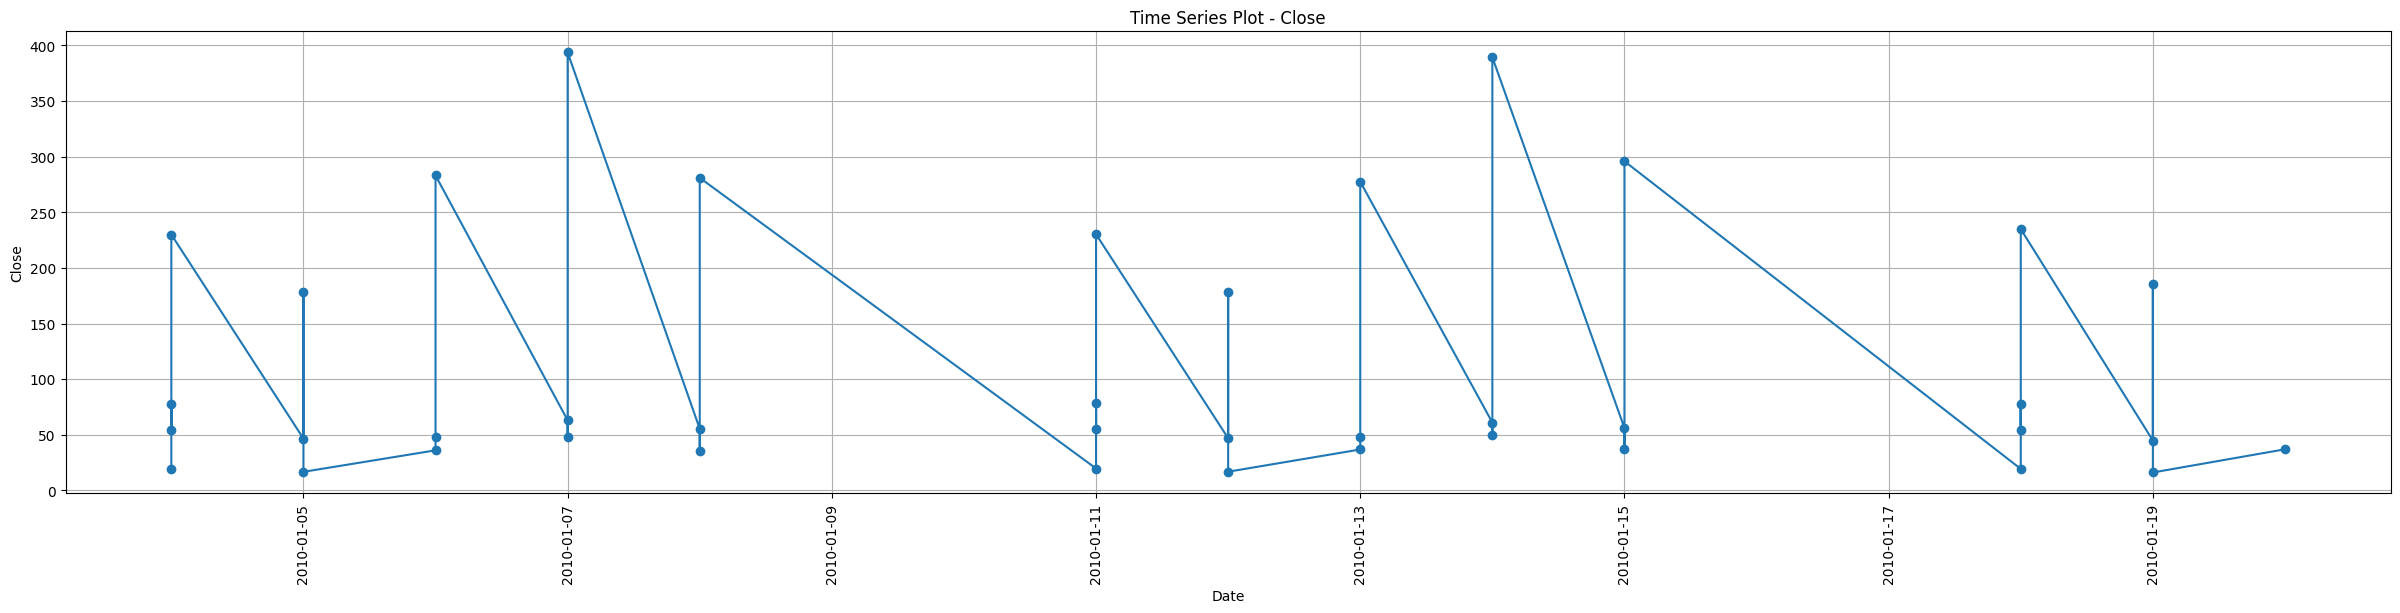

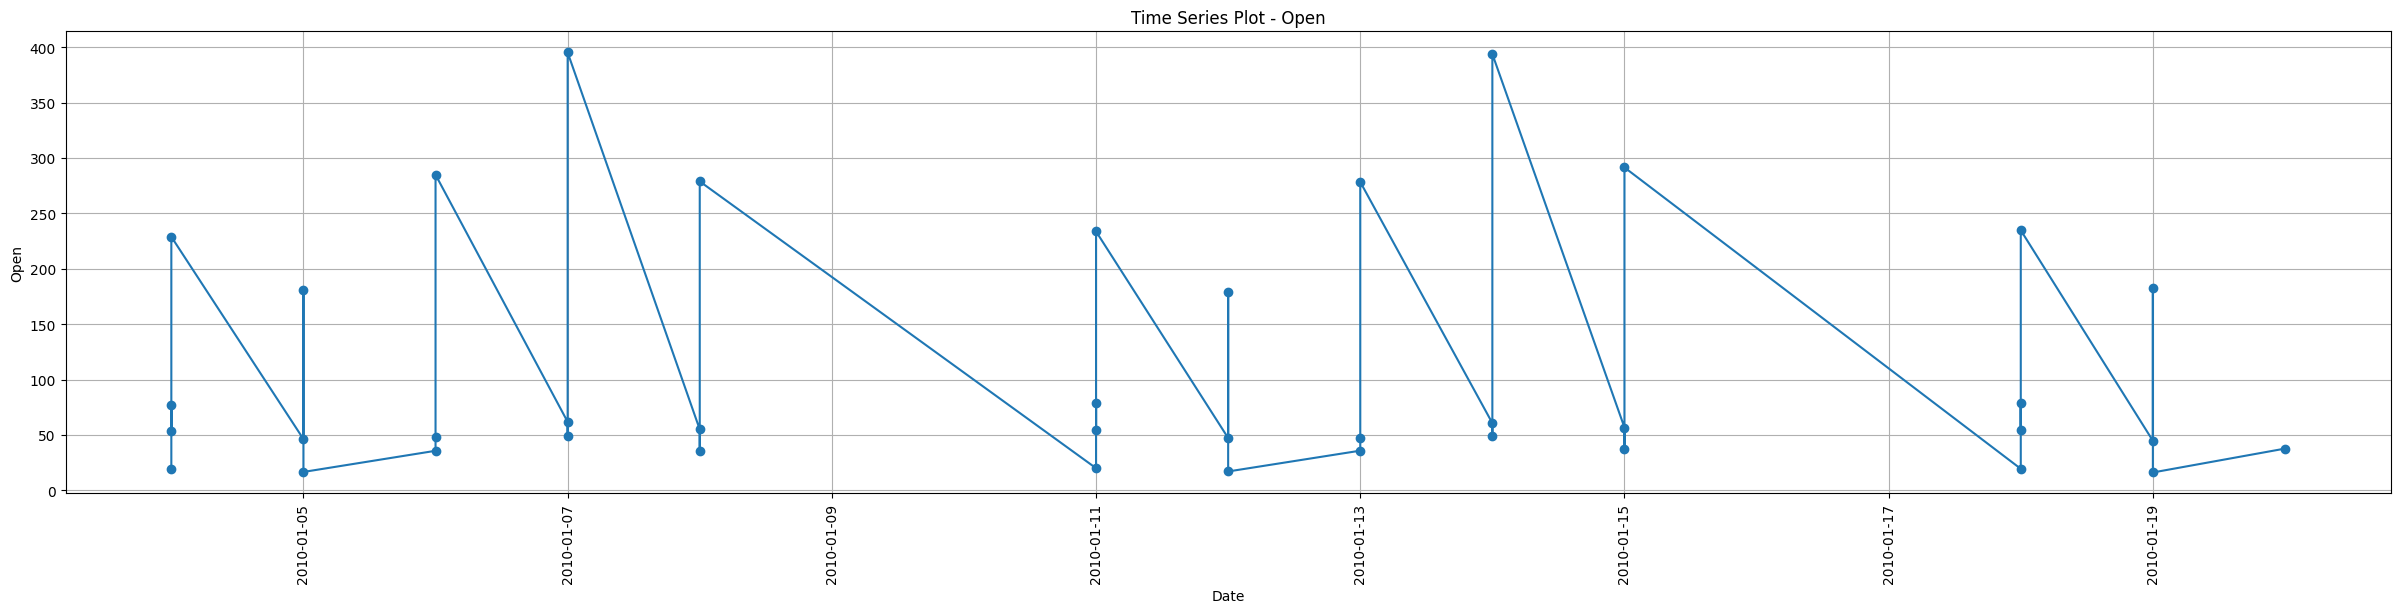

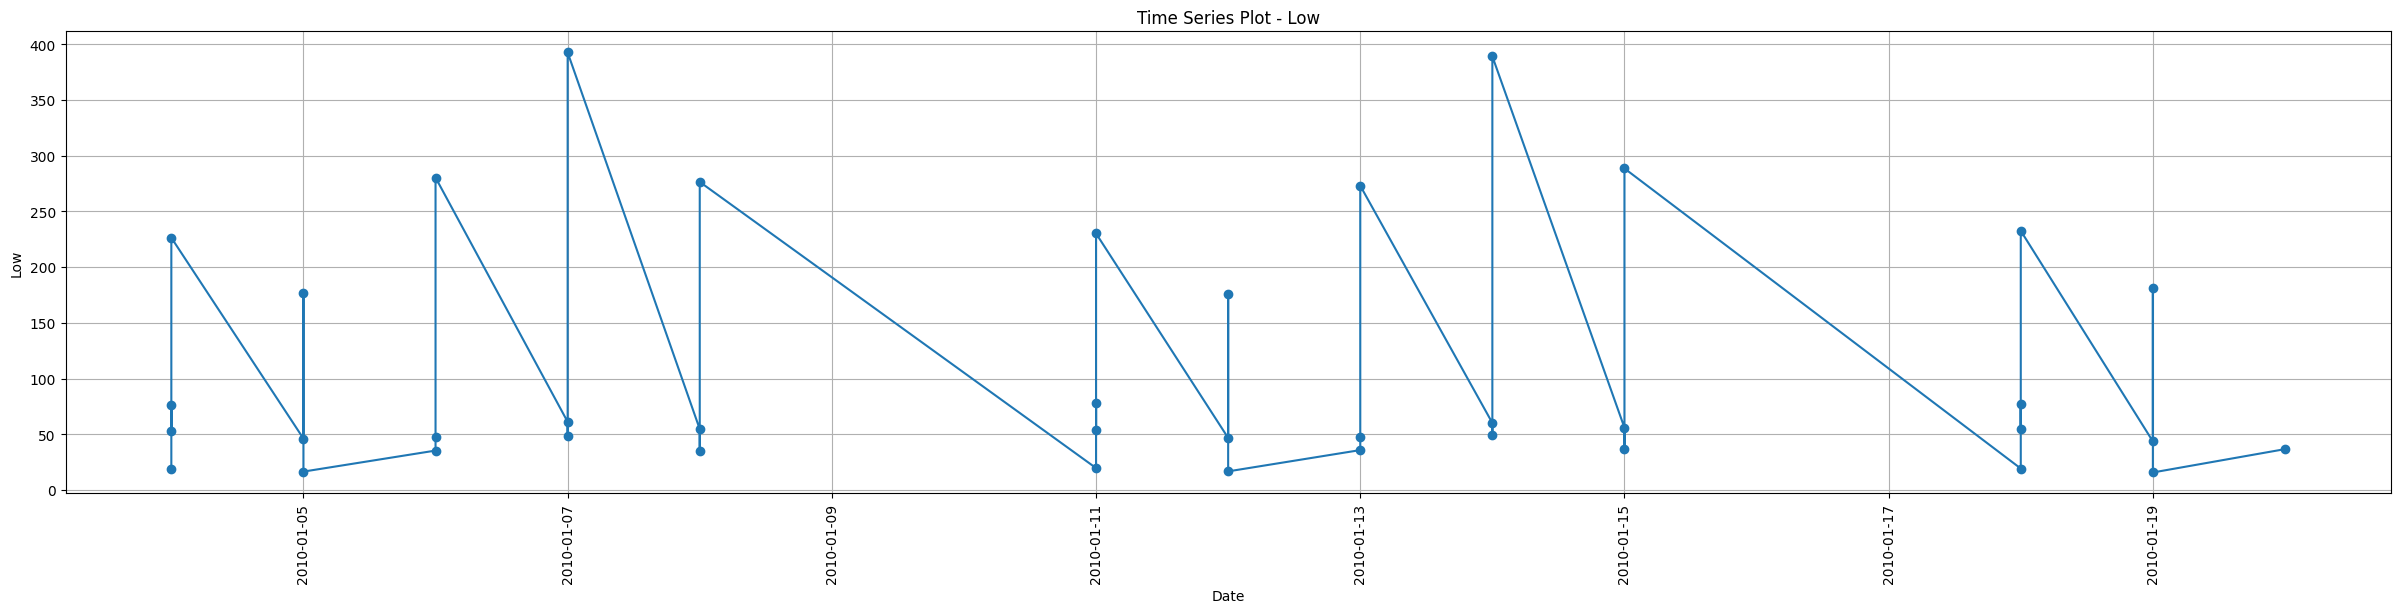

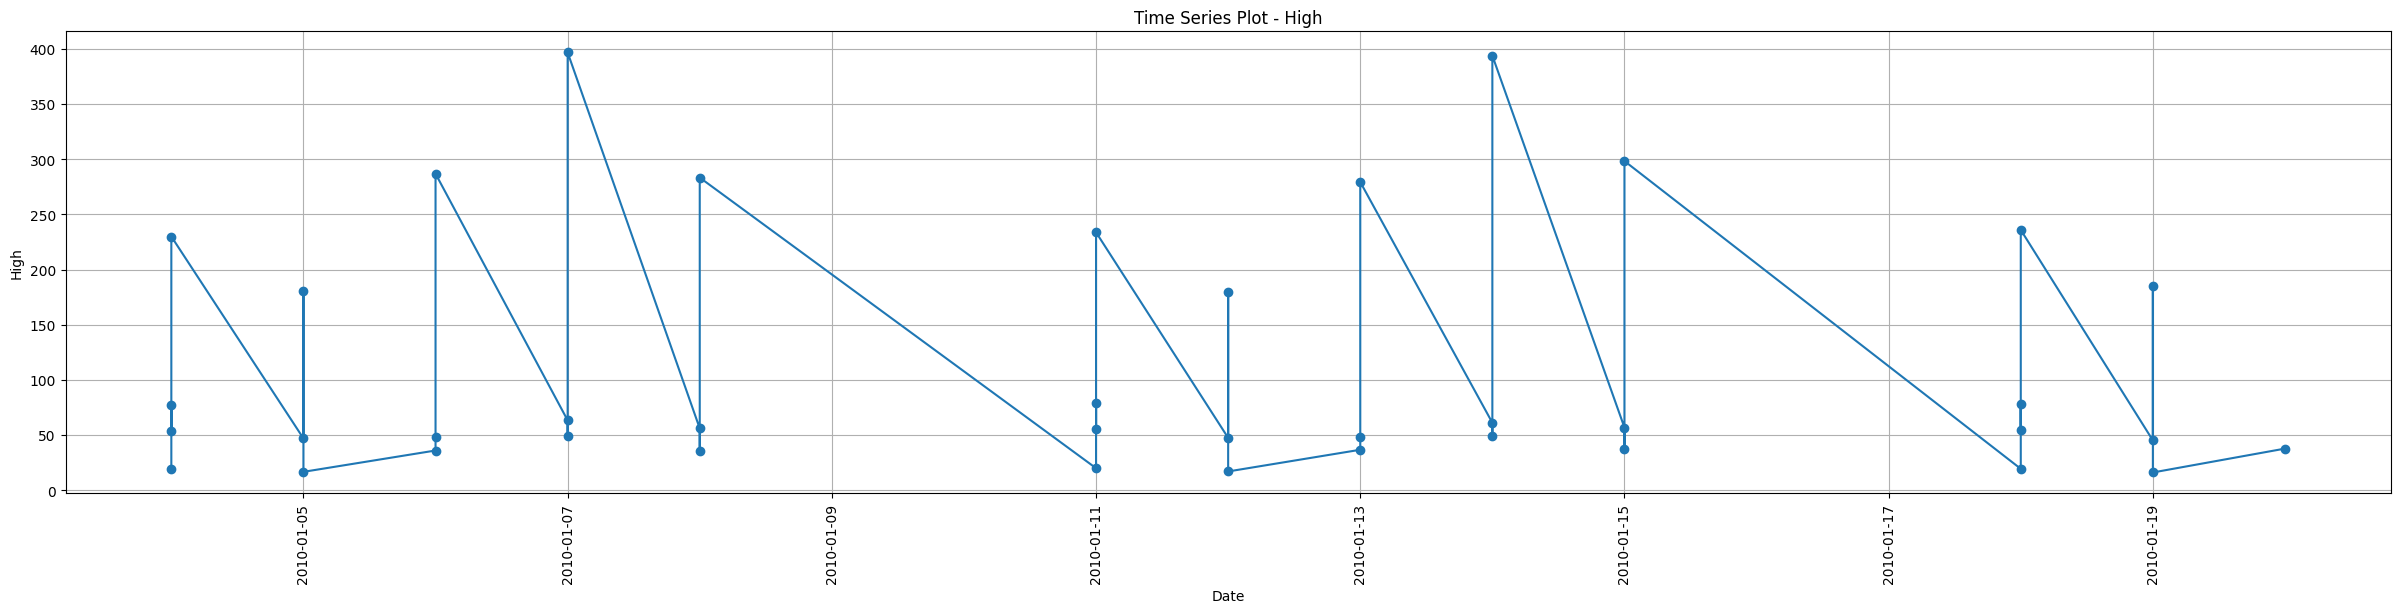

In [ ]:

#Plotting 'data' with a sample rate of 5 and a figure size of (30, 6)
plot_time_series(df1, 'Date', 'Close',sample_n=5,size=(30,6))


#Plotting 'data' with a sample rate of 5 and a figure size of (30, 6)
plot_time_series(df1, 'Date', 'Open',sample_n=5,size=(30,6))



#Plotting 'data' with a sample rate of 5 and a figure size of (30, 6)
plot_time_series(df1, 'Date', 'Low',sample_n=5,size=(30,6))



#Plotting 'data' with a sample rate of 5 and a figure size of (30, 6)
plot_time_series(df1, 'Date', 'High',sample_n=5,size=(30,6))

In [ ]:
# define feature set
features = ['Close', 'Open', 'Low', 'High', 'Volume']
# set multi index, Stock Name as column index
X2 = df.set_index(['Date','Stock_Name'])[features].unstack()
# change to float
X2 = X2.astype(float)
# save X2 as csv file
file_path = 'X2_data.csv'
X2.to_csv(file_path, index=True)

In [ ]:
X2.head()

Close                               \
Stock_Name ABB_Ltd Actelion_Ltd Adecco_Group_AG   
Date                                              
2010-01-04   19.04        54.33            58.5   
2010-01-05   19.13        53.16            60.3   
2010-01-06   19.27        54.18            61.2   
2010-01-07   19.53        55.10            63.0   
2010-01-08   19.79        55.30            63.1   

                                                                               \
Stock_Name Compagnie_Financiere_Richemont_SA Credit_Suisse_Group_AG Holcim_AG   
Date                                                                            
2010-01-04                             35.54                46.0669   77.5714   
2010-01-05                             35.72                46.4971   77.0476   
2010-01-06                             35.97                45.6798   78.3333   
2010-01-07                             36.27                47.4864   78.4762   
2010-01-08                             36.47                48.2176   78.3810   

                                                                         ...  \
Stock_Name Julius_Baer_Gruppe_AG Nestle_SA Novartis_AG Roche_Holding_AG  ...   
Date                                                                     ...   
2010-01-04                 36.20     50.95       48.66            180.7  ...   
2010-01-05                 35.76     49.75       47.82            178.3  ...   
2010-01-06                 35.38     48.96       47.91            179.5  ...   
2010-01-07                 34.97     48.40       47.56            178.0  ...   
2010-01-08                 35.33     49.11       47.56            178.5  ...   

                          Volume                                           \
Stock_Name Julius_Baer_Gruppe_AG   Nestle_SA Novartis_AG Roche_Holding_AG   
Date                                                                        
2010-01-04              792105.0   9387712.0  16460000.0        1911332.0   
2010-01-05             1116146.0  11359540.0  15685313.0        1567373.0   
2010-01-06             1206210.0  12466963.0   8160080.0        1573910.0   
2010-01-07             1134959.0  13079939.0   8910943.0        1542146.0   
2010-01-08             1179163.0  10171279.0   6740959.0        1523677.0   

                                                                           \
Stock_Name    SGS_SA Swatch_Group_AG Swisscom_AG Syngenta_AG UBS_Group_AG   
Date                                                                        
2010-01-04  364075.0        127929.0     64564.0    411693.0   10537927.0   
2010-01-05  414175.0        187276.0    148559.0    431218.0   13218797.0   
2010-01-06  443125.0        307217.0     66028.0    457894.0   10886974.0   
2010-01-07  568450.0        218009.0    112875.0    450188.0   13453101.0   
2010-01-08  406300.0        256179.0    109274.0    354706.0   27061058.0   

                                       
Stock_Name Zuerich_Insurance_Group_AG  
Date                                   
2010-01-04                   686679.0  
2010-01-05                   974130.0  
2010-01-06                   659170.0  
2010-01-07                   835262.0  
2010-01-08                   770634.0  

[5 rows x 80 columns]

<Axes: xlabel='Date'>

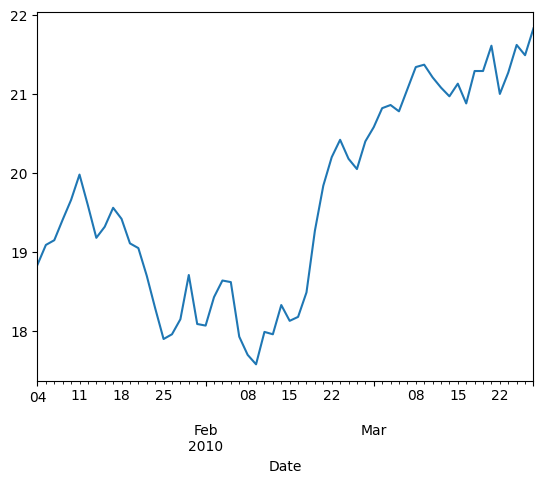

In [ ]:
X2['Open']["ABB_Ltd"][0:60].plot()

<Axes: xlabel='Date'>

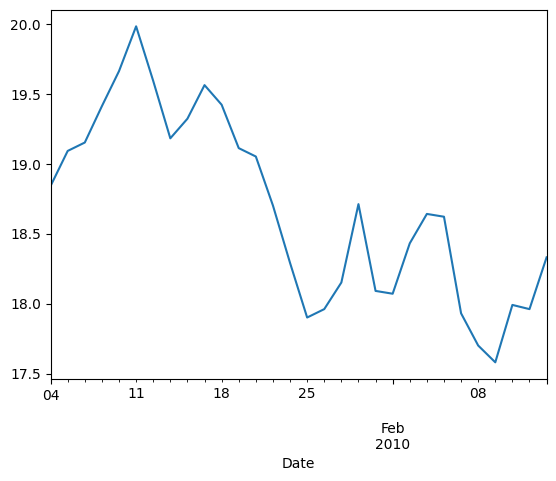

In [ ]:
X2['Open']["ABB_Ltd"][0:30].plot()

<Axes: xlabel='Date'>

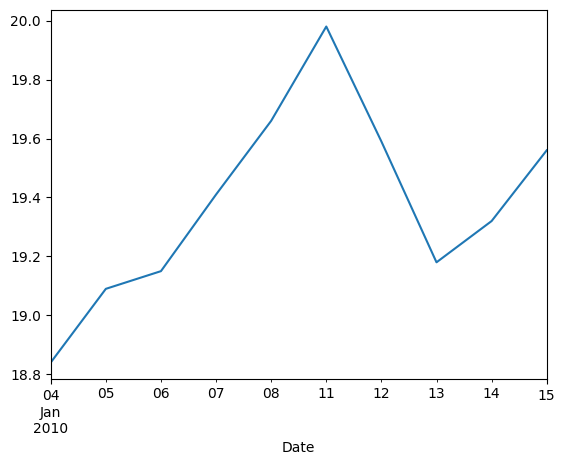

In [ ]:
X2['Open']["ABB_Ltd"][0:10].plot()

In [ ]:
# X3 stores the unscaled values!
X3 = X2.copy()
X4 = X2.copy()

In [ ]:
X3.head()

Close                               \
Stock_Name ABB_Ltd Actelion_Ltd Adecco_Group_AG   
Date                                              
2010-01-04   19.04        54.33            58.5   
2010-01-05   19.13        53.16            60.3   
2010-01-06   19.27        54.18            61.2   
2010-01-07   19.53        55.10            63.0   
2010-01-08   19.79        55.30            63.1   

                                                                               \
Stock_Name Compagnie_Financiere_Richemont_SA Credit_Suisse_Group_AG Holcim_AG   
Date                                                                            
2010-01-04                             35.54                46.0669   77.5714   
2010-01-05                             35.72                46.4971   77.0476   
2010-01-06                             35.97                45.6798   78.3333   
2010-01-07                             36.27                47.4864   78.4762   
2010-01-08                             36.47                48.2176   78.3810   

                                                                         ...  \
Stock_Name Julius_Baer_Gruppe_AG Nestle_SA Novartis_AG Roche_Holding_AG  ...   
Date                                                                     ...   
2010-01-04                 36.20     50.95       48.66            180.7  ...   
2010-01-05                 35.76     49.75       47.82            178.3  ...   
2010-01-06                 35.38     48.96       47.91            179.5  ...   
2010-01-07                 34.97     48.40       47.56            178.0  ...   
2010-01-08                 35.33     49.11       47.56            178.5  ...   

                          Volume                                           \
Stock_Name Julius_Baer_Gruppe_AG   Nestle_SA Novartis_AG Roche_Holding_AG   
Date                                                                        
2010-01-04              792105.0   9387712.0  16460000.0        1911332.0   
2010-01-05             1116146.0  11359540.0  15685313.0        1567373.0   
2010-01-06             1206210.0  12466963.0   8160080.0        1573910.0   
2010-01-07             1134959.0  13079939.0   8910943.0        1542146.0   
2010-01-08             1179163.0  10171279.0   6740959.0        1523677.0   

                                                                           \
Stock_Name    SGS_SA Swatch_Group_AG Swisscom_AG Syngenta_AG UBS_Group_AG   
Date                                                                        
2010-01-04  364075.0        127929.0     64564.0    411693.0   10537927.0   
2010-01-05  414175.0        187276.0    148559.0    431218.0   13218797.0   
2010-01-06  443125.0        307217.0     66028.0    457894.0   10886974.0   
2010-01-07  568450.0        218009.0    112875.0    450188.0   13453101.0   
2010-01-08  406300.0        256179.0    109274.0    354706.0   27061058.0   

                                       
Stock_Name Zuerich_Insurance_Group_AG  
Date                                   
2010-01-04                   686679.0  
2010-01-05                   974130.0  
2010-01-06                   659170.0  
2010-01-07                   835262.0  
2010-01-08                   770634.0  

[5 rows x 80 columns]

# **Train and test data split**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_array = scaler.fit_transform(X3)

In [ ]:
# set patameters lookback & forecast
lookback =10 # look at past 10 days
forecast =40 # forecast the return for the next 60 days

In [ ]:
X = []
Y = []

total_size = len(X3)

for i in range(0, total_size - (lookback+forecast+1)):  # i = row index
    x = data_array[i:i+lookback] # i=0: rows 0-59
    X.append(x)

    #i+lookback, (i+lookback) + forecast are specific rows!
        #NOT a range where the end is not included!
    select = X3.iloc[[ (i+lookback+1), (i+lookback+1) + forecast], 0:n_stocks]
    s = (select.iloc[1,:] - select.iloc[0,:]) / select.iloc[0,:]
    Y.append(s)

In [ ]:
X,Y= np.array(X),np.array(Y)

In [ ]:
# a = X.shape[0] - lookback - forecast
size_train = int(0.8*X.shape[0])
# make sure test set and training set are disjoint!
start_test_set = size_train
X_training = X[:size_train]
Y_training = Y[:size_train]

X_test = X[start_test_set:]
Y_test = Y[start_test_set:]


In [ ]:
# split the training set further in a validation and train set
# make sure they are disjoint
b = X_training.shape[0]
s_train = int(b*(2.5/3))
start_val_set = s_train

X_train = X_training[:s_train]
Y_train = Y_training[:s_train]

X_val = X_training[start_val_set:]
Y_val = Y_training[start_val_set:]

In [ ]:
X_train.shape

(970, 10, 80)

In [ ]:
Y_train.shape

(970, 16)

# **Model training**

In [ ]:
model = Sequential()
model.add(LSTM(units=512, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=64, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=n_stocks,activation='linear'))
model.compile(optimizer ='adam', loss = 'mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Train the model with early stopping
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=12,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
81/81 [==============================] - 22s 97ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 2/100
81/81 [==============================] - 7s 86ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 3/100
81/81 [==============================] - 6s 75ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 4/100
81/81 [==============================] - 7s 91ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 5/100
81/81 [==============================] - 6s 76ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 6/100
81/81 [==============================] - 7s 92ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 7/100
81/81 [==============================] - 6s 74ms/step - loss: 0.0046 - val_loss: 0.0057
Epoch 8/100
81/81 [==============================] - 7s 91ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 9/100
81/81 [==============================] - 6s 75ms/step - loss: 0.0039 - val_loss: 0.0086


In [ ]:
y_pred = model.predict(X_test)
y_pred

10/10 [==============================] - 1s 9ms/step


array([[ 0.03131424,  0.07334969,  0.05185076, ..., -0.0137413 ,
         0.02052932,  0.00831038],
       [ 0.03125599,  0.07348643,  0.05184197, ..., -0.01406605,
         0.02046821,  0.00806988],
       [ 0.03104121,  0.07362755,  0.05167856, ..., -0.01443684,
         0.02021516,  0.00770939],
       ...,
       [ 0.06431507,  0.03883993,  0.07897101, ...,  0.03448533,
         0.05392481,  0.06506486],
       [ 0.06454369,  0.03842622,  0.07893334, ...,  0.03403652,
         0.05420638,  0.06519312],
       [ 0.064766  ,  0.03819885,  0.0790564 , ...,  0.03378386,
         0.05420775,  0.06550226]], dtype=float32)

In [ ]:
d = pd.DataFrame(Y_test.copy())
dz = d.fillna(0).stack().to_frame('real')
dz

real
0   0  -0.038499
    1   0.010720
    2  -0.093438
    3  -0.103041
    4  -0.051296
...          ...
291 11 -0.083965
    12 -0.019493
    13  0.173571
    14 -0.024975
    15 -0.019727

[4672 rows x 1 columns]

In [ ]:
dz['pred'] = [pred[0] for pred in y_pred.reshape((-1,1))]
dz

real      pred
0   0  -0.038499  0.031314
    1   0.010720  0.073350
    2  -0.093438  0.051851
    3  -0.103041  0.019854
    4  -0.051296  0.012882
...          ...       ...
291 11 -0.083965  0.060651
    12 -0.019493  0.024387
    13  0.173571  0.033784
    14 -0.024975  0.054208
    15 -0.019727  0.065502

[4672 rows x 2 columns]

In [ ]:
reg = smf.ols("real ~ pred", dz).fit()

In [ ]:
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
# reg.nobs = number of stocks * number of samples in the test_set

R-squared: 3.47%, N: 4,672


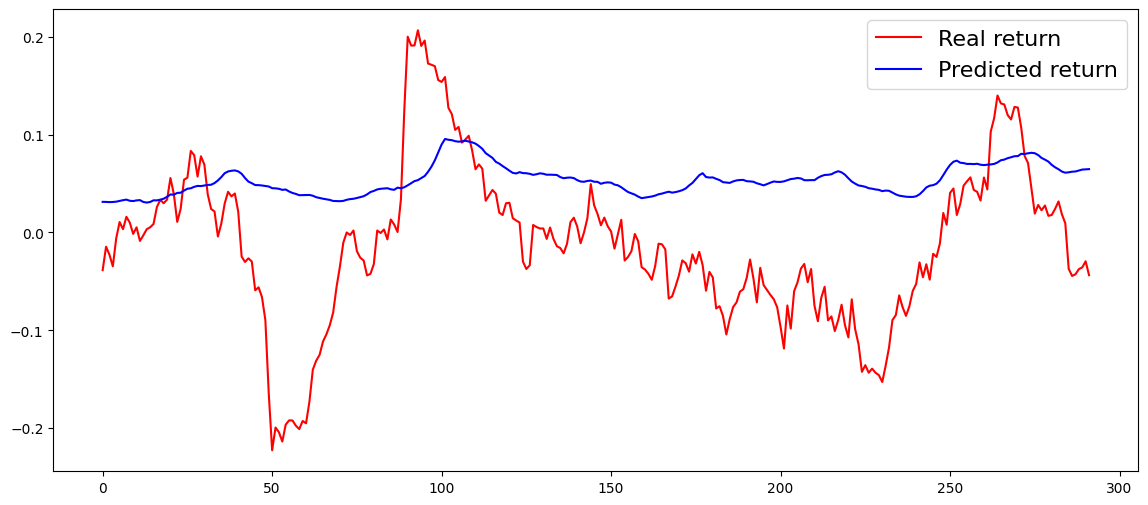

In [ ]:
plt.figure(figsize=(14,6))
# 0: 'Abb_Ltd', set column number 0-15 depending on which stock's graph to plot
plt.plot(Y_test[:,0], color = 'red', label = 'Real return')
plt.plot(y_pred[:,0], color = 'blue', label = 'Predicted return')
plt.legend(loc='best', fontsize=16)
plt.show()

# **FORCASTING prediction and visulization of results**

In [ ]:
# Copy the last forecast days of historical data to use as a starting point for the forecast
current_input =X_test[-forecast:, :, :]
print(current_input.shape)

(40, 10, 80)


In [ ]:
forcast= model.predict(current_input)
forcast

2/2 [==============================] - 0s 20ms/step


array([[0.07343177, 0.03169352, 0.09037033, 0.07192834, 0.07977165,
        0.06026544, 0.04261375, 0.03231466, 0.02093769, 0.05129594,
        0.04225704, 0.07378861, 0.02623036, 0.04671403, 0.06917237,
        0.07496393],
       [0.07133716, 0.02929019, 0.08561946, 0.06962465, 0.07690439,
        0.05522901, 0.04081031, 0.0310603 , 0.02009489, 0.04790725,
        0.03873296, 0.07222695, 0.02454708, 0.04231208, 0.06941106,
        0.0708839 ],
       [0.07093957, 0.02794928, 0.0842008 , 0.06936803, 0.07636783,
        0.05362805, 0.04061921, 0.03069822, 0.01973309, 0.04632846,
        0.03773066, 0.07227731, 0.02379765, 0.04078418, 0.07009362,
        0.06951948],
       [0.07006782, 0.02743391, 0.0821591 , 0.06805962, 0.07532669,
        0.05124424, 0.03975599, 0.03009425, 0.01948289, 0.04510073,
        0.03605143, 0.07132763, 0.02312019, 0.03856697, 0.07008678,
        0.06768908],
       [0.07010916, 0.0271026 , 0.08170048, 0.06802145, 0.07556203,
        0.05093298, 0.03978289, 

In [ ]:
dates =dz.index[-len(Y_test):]

index=[]
for i in range(len(forcast)):
  ind1=dates[-1][0]+1+i
  for j in range(16):
    ind2=(ind1,+j)
    index.append(ind2)

In [ ]:
forc= pd.DataFrame(forcast.copy())
forc = forc.fillna(0).stack().to_frame('forc')
forc.index= pd.MultiIndex.from_tuples(index)

In [ ]:
forc=forc.unstack()

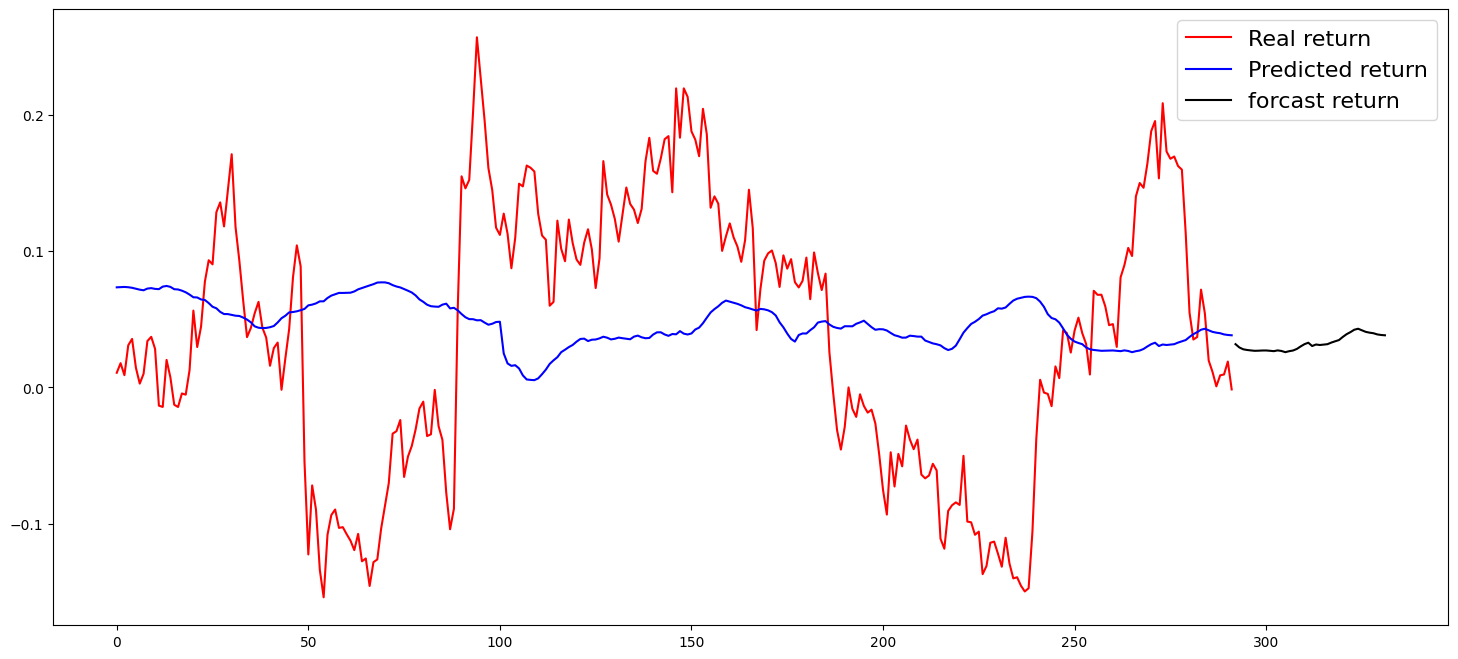

In [ ]:
plt.figure(figsize=(18, 8))

plt.plot(Y_test[:,1], color = 'red', label = 'Real return')
plt.plot(y_pred[:,1], color = 'blue', label = 'Predicted return')
plt.plot(forc.iloc[:,1], color = 'black', label = 'forcast return')

plt.legend(loc='best', fontsize=16)
plt.show()